In [1]:
import sklearn
import pandas as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from functools import partial
from pathlib import Path
import os

# Initial load and drop irrelevant files.

Creates a function to go from location_key to the real county name

In [2]:
df = pd.read_csv("../../data/usa_covid_all.csv")
# df = pd.read_csv("../../data/usa_covid_gt20.csv")
#date
df['date'] = pd.to_datetime(df['date'])

#remove unrelated features
df = df.drop(columns=['aggregation_level','latitude','longitude','openstreetmap_id','location_geometry','datacommons_id','wikidata_id','iso_3166_1_alpha_2','iso_3166_1_alpha_3'])

#drop country and per state rows
df = df.dropna(axis='index', subset=['subregion2_code'])

#remove location names and make map
df = df.astype({'subregion2_code':int})
names = df[['subregion1_name','subregion2_name','subregion2_code']].drop_duplicates(subset=['subregion2_code'])
def codeNameConverter(code, names):
    if isinstance(code, str):
        code = int(code.split("_")[2])
    res = names[names['subregion2_code'] == code]
    return f"{res.iloc[0]['subregion2_name']}, {res.iloc[0]['subregion1_name']}"
codeToName = partial(codeNameConverter, names=names)
df = df.drop(columns=['country_code', 'country_name','subregion1_code','subregion1_name','subregion2_code','subregion2_name'])



# Clean data and interpolate columns where required

Make sure no values are missing

In [3]:
#imputations!
#assume nan for rain and snow means 0
df['rainfall_mm'].fillna(0,inplace=True)
df['snowfall_mm'].fillna(0,inplace=True)

#interpolate missing temperatures, can't remove as there are some days with covid cases
df['average_temperature_celsius'] = df['average_temperature_celsius'].interpolate()
df['minimum_temperature_celsius'] = df['minimum_temperature_celsius'].interpolate()
df['maximum_temperature_celsius'] = df['maximum_temperature_celsius'].interpolate()

#fill mobility reports with 0 for na since its a relative % to baseline
df['mobility_transit_stations'] = df['mobility_transit_stations'].interpolate()
df['mobility_retail_and_recreation'] = df['mobility_retail_and_recreation'].interpolate()
df['mobility_grocery_and_pharmacy'] = df['mobility_grocery_and_pharmacy'].interpolate()
df['mobility_residential'] = df['mobility_residential'].interpolate()
df['mobility_parks'] = df['mobility_parks'].interpolate()
df['mobility_workplaces'] = df['mobility_workplaces'].interpolate()

#drop columns with too many nan (that we couldnt impute)
df = df.dropna(thresh=len(df)*.3,axis=1)

df = df.fillna(0)

In [4]:
df.describe()

,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,mobility_transit_stations,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_residential,mobility_workplaces,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm
count,1.009425e+06,1.009425e+06,1.009425e+06,1.009425e+06,1.009425e+06,1.009425e+06,1.009425e+06,1.009425e+06,1.009425e+06,1.009425e+06,1.009425e+06,1.009425e+06,1.009425e+06,1.009425e+06,1.009425e+06
mean,9.678879e+00,2.280278e-01,9.056195e+02,2.953121e+01,-7.516504e+00,-9.840237e+00,2.186294e-01,8.579616e+00,4.270807e+00,-1.908773e+01,1.506153e+01,9.522498e+00,2.158387e+01,2.209783e+00,7.357387e+00
std,6.031254e+01,2.379450e+00,5.445071e+03,2.071297e+02,2.059708e+01,1.933123e+01,1.347023e+01,4.214528e+01,4.814086e+00,1.463853e+01,9.906670e+00,9.943172e+00,1.026850e+01,5.635624e+00,4.317185e+01
min,-2.321000e+03,-5.120000e+02,0.000000e+00,0.000000e+00,-9.200000e+01,-1.000000e+02,-9.600000e+01,-9.100000e+01,-4.600000e+01,-9.200000e+01,-4.156944e+01,-4.492778e+01,-3.802778e+01,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.870225e+01,-2.085505e+01,-7.000000e+00,-1.716157e+01,1.106557e+00,-2.876923e+01,7.722222e+00,2.033333e+00,1.444444e+01,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,2.900000e+01,0.000000e+00,-4.389140e+00,-7.000000e+00,-3.971587e-01,4.882275e+00,3.000000e+00,-1.866667e+01,1.672778e+01,1.039444e+01,2.387778e+01,8.466700e-02,0.000000e+00
75%,4.000000e+00,0.000000e+00,2.970000e+02,6.000000e+00,4.580645e+00,2.000000e+00,6.267361e+00,2.303678e+01,6.000000e+00,-7.393443e+00,2.340741e+01,1.777222e+01,2.993333e+01,1.721556e+00,0.000000e+00
max,1.412900e+04,4.550000e+02,3.177270e+05,7.157000e+03,2.520000e+02,2.610000e+02,2.250000e+02,7.090000e+02,3.800000e+01,6.600000e+01,3.983333e+01,3.255000e+01,4.773611e+01,1.963420e+02,1.750060e+03


In [5]:
df.count()

date                              1009425
location_key                      1009425
new_confirmed                     1009425
new_deceased                      1009425
cumulative_confirmed              1009425
cumulative_deceased               1009425
mobility_transit_stations         1009425
mobility_retail_and_recreation    1009425
mobility_grocery_and_pharmacy     1009425
mobility_parks                    1009425
mobility_residential              1009425
mobility_workplaces               1009425
average_temperature_celsius       1009425
minimum_temperature_celsius       1009425
maximum_temperature_celsius       1009425
rainfall_mm                       1009425
snowfall_mm                       1009425
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009425 entries, 0 to 1028204
Data columns (total 17 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   date                            1009425 non-null  datetime64[ns]
 1   location_key                    1009425 non-null  object        
 2   new_confirmed                   1009425 non-null  float64       
 3   new_deceased                    1009425 non-null  float64       
 4   cumulative_confirmed            1009425 non-null  float64       
 5   cumulative_deceased             1009425 non-null  float64       
 6   mobility_transit_stations       1009425 non-null  float64       
 7   mobility_retail_and_recreation  1009425 non-null  float64       
 8   mobility_grocery_and_pharmacy   1009425 non-null  float64       
 9   mobility_parks                  1009425 non-null  float64       
 10  mobility_residential            1009425 no

array([[<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>]],
      dtype=object)

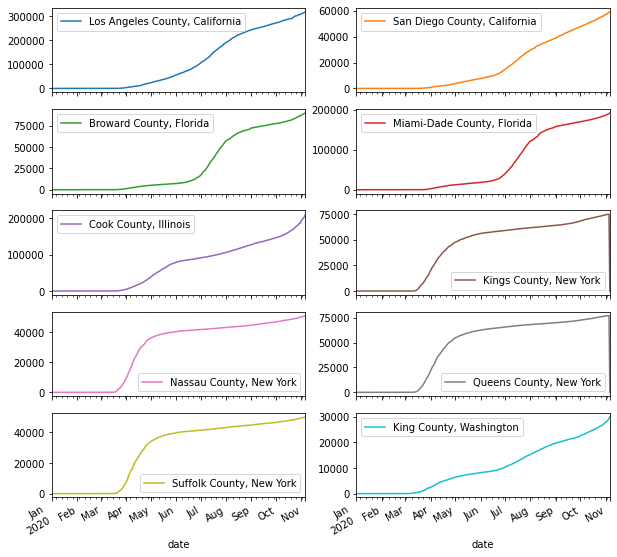

In [7]:
# grouped = df_filt.groupby(['location_key']).filter(lambda x : x['new_confirmed'].count() > 200)
num=10
top=df[df['new_confirmed']>25].groupby('location_key').agg({'date' : np.size}).sort_values('date',ascending=False)[0:num]
df_filt = df[df['location_key'].isin(top.index)].fillna(0)

majorcounties = df_filt.pivot(index="date",columns="location_key", values="cumulative_confirmed")
majorcounties = majorcounties.drop(majorcounties.tail(2).index)
majorcounties.columns = [codeToName(x) for x in majorcounties.columns]

majorcounties.plot(subplots=True,layout=(num//2,2),figsize=(10,num))

In [8]:
# majorcounties.columns

array([[<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>]],
      dtype=object)

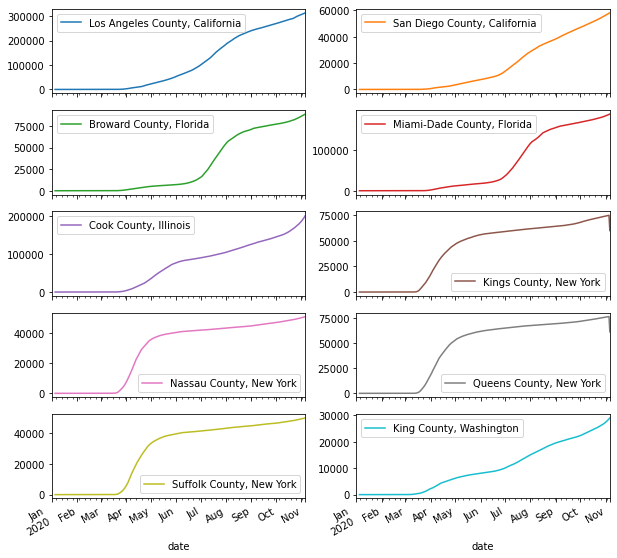

In [9]:
majorcounties_smth = majorcounties.rolling(5).mean()
majorcounties_smth.plot(subplots=True,layout=(num//2,2),figsize=(10,num))

In [10]:
for x in df_filt["location_key"].unique():
    print(codeToName(x))

King County, Washington
Kings County, New York
Nassau County, New York
Queens County, New York
Suffolk County, New York
Los Angeles County, California
San Diego County, California
Cook County, Illinois
Broward County, Florida
Miami-Dade County, Florida


In [11]:
df_filt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3130 entries, 157136 to 841777
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            3130 non-null   datetime64[ns]
 1   location_key                    3130 non-null   object        
 2   new_confirmed                   3130 non-null   float64       
 3   new_deceased                    3130 non-null   float64       
 4   cumulative_confirmed            3130 non-null   float64       
 5   cumulative_deceased             3130 non-null   float64       
 6   mobility_transit_stations       3130 non-null   float64       
 7   mobility_retail_and_recreation  3130 non-null   float64       
 8   mobility_grocery_and_pharmacy   3130 non-null   float64       
 9   mobility_parks                  3130 non-null   float64       
 10  mobility_residential            3130 non-null   float64       
 1

Append population density to filtered covid data and save

In [12]:
df_filt['County_ID'] = df_filt['location_key'].apply(lambda x : x.split("_")[2])
df_filt['County_ID'] = pd.to_numeric(df_filt['County_ID'])

path = Path("../../data/popdens")
df = pd.read_csv(path / "0_50_n.csv")
df = df[0:0]
for x in path.iterdir():
    df=pd.concat([df,pd.read_csv(x)],ignore_index=True)
df['County_ID'] = pd.to_numeric(df['County_ID'])

In [13]:
# temp = pd.read_csv("../../data/cams_data.csv")
# temp.info()

In [14]:
res = pd.merge(df_filt,df,how='left',on='County_ID')
res = res.drop(labels=["location_key","State","County","Mesure"],axis='columns')
res = res.drop(labels=["rainfall_mm","snowfall_mm"], axis='columns')
res = res.rename(columns={"County_ID" : "county_id", "Pop_density" : "pop_density"})
res = res.drop(["average_temperature_celsius", "minimum_temperature_celsius", "maximum_temperature_celsius"], axis=1)
res.to_csv("../../data_processed/usa_top30_with_density")
res

,date,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,mobility_transit_stations,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_residential,mobility_workplaces,county_id,pop_density
0,2020-01-01,0.0,0.0,0.0,0.0,1.076923,-9.490566,-2.223881,59.396226,5.727273,-12.339623,53033,937.2
1,2020-01-02,0.0,0.0,0.0,0.0,1.230769,-9.301887,-2.218905,58.320755,5.600000,-12.132075,53033,937.2
2,2020-01-03,0.0,0.0,0.0,0.0,1.384615,-9.113208,-2.213930,57.245283,5.472727,-11.924528,53033,937.2
3,2020-01-04,0.0,0.0,0.0,0.0,1.538462,-8.924528,-2.208955,56.169811,5.345455,-11.716981,53033,937.2
4,2020-01-05,0.0,0.0,0.0,0.0,1.692308,-8.735849,-2.203980,55.094340,5.218182,-11.509434,53033,937.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3125,2020-11-04,1382.0,-5.0,189498.0,3670.0,-43.000000,-21.301887,-14.245283,-39.396226,4.716981,-17.981132,12086,NaN
3126,2020-11-05,1070.0,0.0,190568.0,3670.0,-42.000000,-20.735849,-13.660377,-38.528302,4.622642,-17.641509,12086,NaN
3127,2020-11-06,1110.0,1.0,191837.0,3671.0,-41.000000,-20.169811,-13.075472,-37.660377,4.528302,-17.301887,12086,NaN
3128,2020-11-07,0.0,0.0,0.0,0.0,-40.000000,-19.603774,-12.490566,-36.792453,4.433962,-16.962264,12086,NaN
